# A/B Test Significance in Python
**Samuel Hinton - [CosmicCoding](https://cosmiccoding.com.au/tutorials/ab_tests)**

## Example Problem
Let us assume you have:
- 1000 users
- 550 were directed to site A, 450 to site B
- In site A, 48 users converted
- In site B, 56 users converted

**Is this a statistically significant result?**

## 1. Manual Method

In [47]:
num_a, num_b = 550, 450
click_a, click_b = 48, 56
rate_a, rate_b = click_a / num_a, click_b / num_b
print('Rate A = {} | Rate B = {}'.format(rate_a, rate_b))

Rate A = 0.08727272727272728 | Rate B = 0.12444444444444444


Button clicks are binary (two discrete options are available) so this is a textbook binomial distribution, with some unknown rate for site A and site B. We don’t know the true click rate, but we can estimate it using our small sample.

In [48]:
# Imports
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np

### Use Bionomial Probability Mass Function (pmf) to compare the cases

In [70]:
# Determine the probability of having x number of click throughs
clicks = np.arange(20, 80) # A range that captures the 48 and 56 clicks well
bion_prob_a = binom(num_a, rate_a).pmf(clicks) # A bionomial distribution with sample size num_a and probability rate_a
bion_prob_b = binom(num_b, rate_b).pmf(clicks) # A bionomial distribution with sample size num_b and probability rate_b

Text(0, 0.5, 'Probability')

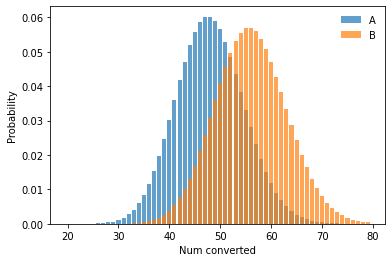

In [76]:
# Make bar plots to compare the pmf distributions
plt.bar(clicks, bion_prob_a, label="A", alpha=0.7)
plt.bar(clicks, bion_prob_b, label="B", alpha=0.7)
plt.legend(frameon=False)
plt.xlabel("Num converted"); plt.ylabel("Probability")

- **B** has an edge
- But it is certaintly possible if we pick two random points according to the histograms for **A** and **B**, that **A** might actually be higher than **B**!

### Use Normal Distribution Approximation of Bionomial Distribution

As we’re interested in the average conversion, or average time spent on the site, this averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution.

In [77]:
from scipy.stats import norm

Get standard deviations for A and B using the [normal approx of bionomial distributions](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation)

In [78]:
# Takes form sqrt(p*(1-p)/n)
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

### Get Normal Distribution Probability Distribution Function (pdf) to compare the cases

In [79]:
# Turn into distributions
click_rate = np.linspace(0, 0.2, 200)
norm_prob_a = norm(rate_a, std_a).pdf(click_rate)
norm_prob_b = norm(rate_b, std_b).pdf(click_rate)

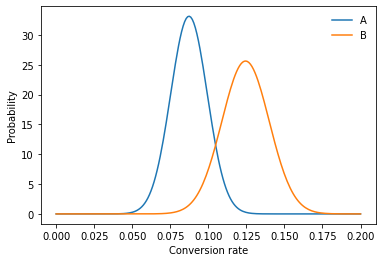

In [80]:
# Make bar plots to compare the cases
plt.plot(click_rate, norm_prob_a, label="A")
plt.plot(click_rate, norm_prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

- This is a better plot than the first one, because we’ve removed the confusing effect of site A and site B having a slightly different number of visitors had
- But the question is still the same: What is the chance that a draw from B is higher than a draw from A?
- Is it significant?

#### To answer this, use the fact that the sum (or difference) of normally distributed random numbers is also a normal
[Proof here](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables)

In [84]:
# 1. Get the difference in the means (rates)
rate_diff = rate_b - rate_a

In [85]:
# 2. Get the sums of the variance
var_sum = np.sqrt(std_a**2 + std_b**2)

In [86]:
# 3. Get the z-score
z_score = rate_diff / var_sum

In [87]:
# 4. Get the distribution
p = norm(rate_diff, var_sum)

Text(0, 0.5, 'Prob')

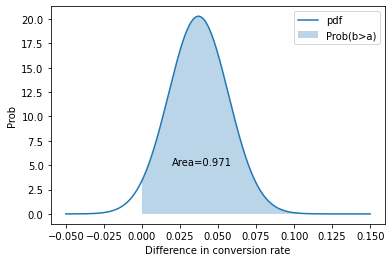

In [90]:
# 5. Plot the distribution
x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="pdf")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob")

In [89]:
print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

zscore is 1.890, with p-value 0.029


### Interpret the Result

Using the frequentist approach, we would say:
- Given the null hypothesis is true (that B is less then or equal to A)
- We would expect to get this result or a result more extreme only 2.9% of the time
- As that is a significant result (typically p < 5%), we reject the null hypothesis
- And state that we have **evidence that B > A**

### 1-Sided vs 2-Sided Tests

- This was a one-tailed test - the question asked iwas if B > A
- An alterative is the two-tailed test, where we just want to discriminate that B is different to A
- In that case, our p-value is actually: **2 × 2.9 = 5.8** (as we have two tails, not one)
- In that case we would want more samples before rejecting the null hypothesis if we stick to the p-value of 0.05 threshold.

### Alternately, Collapse into Simple Confidence Interval Function

In [91]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

In [98]:
print(get_confidence_ab_test(48, 550, 56, 450))

0.9705973498275782


=> B is significantly higher than A at a 5% confidence level

## 2. Scipy Builtin Methods

### 2.1 Welsch's t-test

In [102]:
from scipy.stats import ttest_ind
a_dist = np.zeros(num_a)
a_dist[:click_a] = 1 # Turn the clicks and non clicks into an array of 1's and 0's
b_dist = np.zeros(num_b)
b_dist[:click_b] = 1 # Turn the clicks and non clicks into an array of 1's and 0's
zscore, prob = ttest_ind(a_dist, b_dist, equal_var=False)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -1.89, p-value is 0.059 (two tailed), 0.030 (one tailed)


### 2.2 Mann-Whitney U-test

In [103]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="less")
print(f"Mann-Whitney U test for null hypothesis B <= A is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis B <= A is 0.028
